In [1]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
from pathlib import Path

data_path = Path("EmotionDataset")

# Define training and test paths
train_path = data_path / "train"
test_path = data_path / "test"

# List class folders
train_classes = sorted([folder.name for folder in train_path.iterdir() if folder.is_dir()])
test_classes = sorted([folder.name for folder in test_path.iterdir() if folder.is_dir()])

print("Train classes:", train_classes)
print("Test classes:", test_classes)

# Count number of images in each class
print("\n--- Train Set ---")
for cls in train_classes:
    count = len(list((train_path / cls).glob("*.jpg")))
    print(f"Class {cls}: {count} images")

print("\n--- Test Set ---")
for cls in test_classes:
    count = len(list((test_path / cls).glob("*.jpg")))
    print(f"Class {cls}: {count} images")

Train classes: ['1', '2', '3', '4', '5', '6', '7']
Test classes: ['1', '2', '3', '4', '5', '6', '7']

--- Train Set ---
Class 1: 1290 images
Class 2: 281 images
Class 3: 717 images
Class 4: 4772 images
Class 5: 1982 images
Class 6: 705 images
Class 7: 2524 images

--- Test Set ---
Class 1: 329 images
Class 2: 74 images
Class 3: 160 images
Class 4: 1185 images
Class 5: 478 images
Class 6: 162 images
Class 7: 680 images


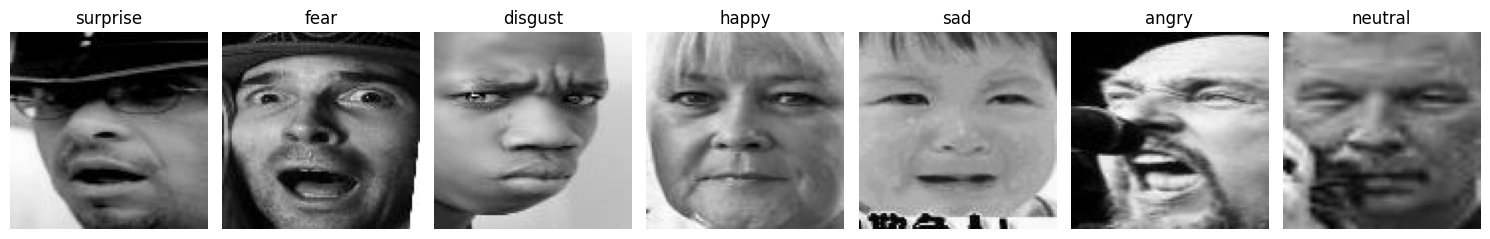

In [3]:
emotion_labels = {
    "1": "surprise",
    "2": "fear",
    "3": "disgust",
    "4": "happy",
    "5": "sad",
    "6": "angry",
    "7": "neutral"
}

fig, axs = plt.subplots(1, 7, figsize=(15, 3))
for idx, cls in enumerate(train_classes):
    sample_image_path = next((train_path / cls).glob("*.jpg"))
    img = Image.open(sample_image_path)
    axs[idx].imshow(img.convert("L"), cmap="gray")
    axs[idx].set_title(emotion_labels[cls])
    axs[idx].axis("off")
plt.tight_layout()
plt.show()

In [4]:
class RAFDataset(Dataset):
    def __init__(self, root_dir, transform, image_size=96):
        self.root_dir = root_dir
        self.image_paths = []
        self.labels = []
        self.transform = transform  # dışarıdan alınan transform

        for label in range(1, 8):  # Class labels: 1 to 7
            class_folder = os.path.join(root_dir, str(label))
            if not os.path.exists(class_folder):
                continue
            for file in os.listdir(class_folder):
                if file.endswith(".jpg"):
                    self.image_paths.append(os.path.join(class_folder, file))
                    self.labels.append(label - 1)  # Convert to 0-based indexing

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        image = self.transform(image)
        label = self.labels[idx]
        return image, label

Total training samples: 12271
Total testing samples: 3068


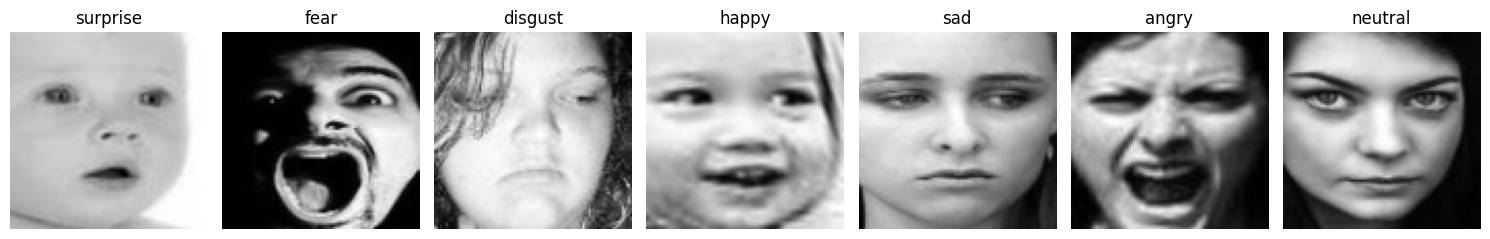

In [5]:
from torchvision import transforms

# Define transforms separately for train and test
train_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((96, 96)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((96, 96)),
    transforms.ToTensor()
])

# Load datasets using custom class
train_dataset = RAFDataset("EmotionDataset/train", transform=train_transform)
test_dataset = RAFDataset("EmotionDataset/test", transform=test_transform)

print(f"Total training samples: {len(train_dataset)}")
print(f"Total testing samples: {len(test_dataset)}")

# Show one example per class from the **test** set (no augmentation)
emotion_names = ["surprise", "fear", "disgust", "happy", "sad", "angry", "neutral"]

fig, axs = plt.subplots(1, 7, figsize=(15, 3))
shown_labels = set()
i = 0
for img, label in test_dataset:
    if label not in shown_labels:
        axs[i].imshow(img.squeeze(), cmap="gray")
        axs[i].set_title(emotion_names[label])
        axs[i].axis("off")
        shown_labels.add(label)
        i += 1
    if len(shown_labels) == 7:
        break
plt.tight_layout()
plt.show()

In [6]:
import torch.nn as nn

class EmotionCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64x48x48

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 128x24x24

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 256x12x12

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # 512x1x1
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [7]:
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight

# Set device to MPS (Apple GPU) if available, otherwise fallback to CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Using device:", device)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Initialize model and move to device
model = EmotionCNN().to(device)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_dataset.labels),
    y=train_dataset.labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-5)

Using device: mps


In [8]:
num_epochs = 75

train_losses, train_accuracies = [], []
val_losses,   val_accuracies   = [], []

for epoch in range(num_epochs):
    # ---------- TRAIN ----------
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total   += labels.size(0)
        correct += (preds == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc  = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # ---------- VALIDATION ----------
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            v_loss  = criterion(outputs, labels)

            val_running_loss += v_loss.item()
            _, preds = torch.max(outputs, 1)
            val_total   += labels.size(0)
            val_correct += (preds == labels).sum().item()

    val_epoch_loss = val_running_loss / len(test_loader)
    val_epoch_acc  = 100 * val_correct / val_total
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"- train_loss: {epoch_loss:.4f}  train_acc: {epoch_acc:.2f}% "
          f"- val_loss: {val_epoch_loss:.4f}  val_acc: {val_epoch_acc:.2f}%")

Epoch [1/75] - train_loss: 1.9573  train_acc: 18.74% - val_loss: 2.2724  val_acc: 6.36%
Epoch [2/75] - train_loss: 1.8965  train_acc: 20.54% - val_loss: 1.8635  val_acc: 23.01%
Epoch [3/75] - train_loss: 1.8734  train_acc: 22.70% - val_loss: 1.8617  val_acc: 26.92%
Epoch [4/75] - train_loss: 1.8577  train_acc: 25.64% - val_loss: 1.8079  val_acc: 29.30%
Epoch [5/75] - train_loss: 1.8345  train_acc: 27.68% - val_loss: 1.7931  val_acc: 32.01%
Epoch [6/75] - train_loss: 1.7208  train_acc: 36.30% - val_loss: 1.5627  val_acc: 42.80%
Epoch [7/75] - train_loss: 1.5788  train_acc: 44.60% - val_loss: 1.7481  val_acc: 39.08%
Epoch [8/75] - train_loss: 1.4584  train_acc: 50.75% - val_loss: 1.3504  val_acc: 52.12%
Epoch [9/75] - train_loss: 1.3509  train_acc: 53.83% - val_loss: 1.3606  val_acc: 48.73%
Epoch [10/75] - train_loss: 1.2767  train_acc: 57.75% - val_loss: 1.1446  val_acc: 58.87%
Epoch [11/75] - train_loss: 1.1784  train_acc: 61.01% - val_loss: 1.2449  val_acc: 53.36%
Epoch [12/75] - trai

In [9]:
model_path = "emotion_modelv1.pt"
torch.save(model.state_dict(), model_path)
print(f"Model saved to: {model_path}")

Model saved to: emotion_modelv1.pt


In [10]:
!pip install seaborn

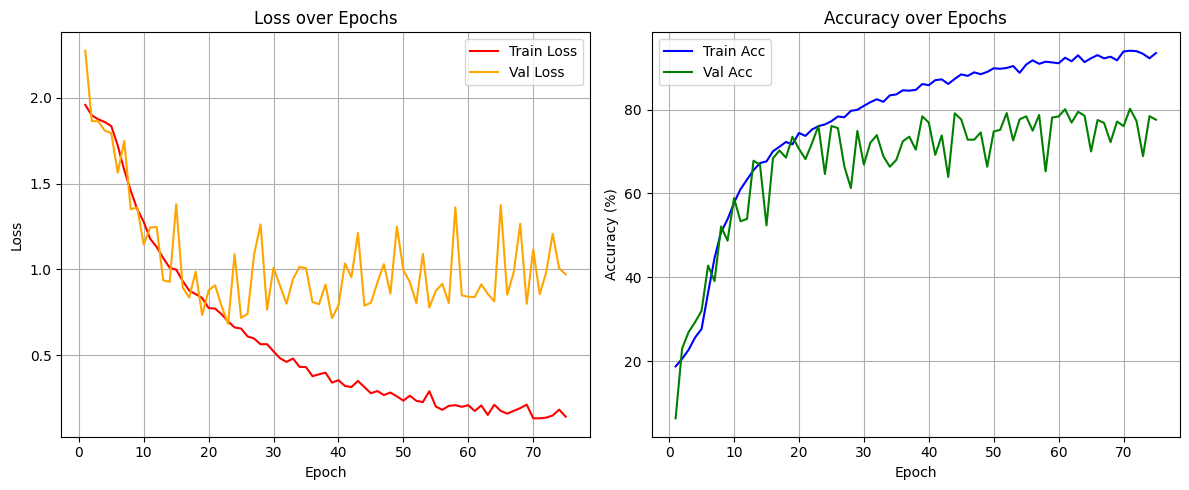

In [11]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

# ---- Loss ----
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss", color="red")
plt.plot(epochs, val_losses,   label="Val Loss",   color="orange")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# ---- Accuracy ----
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Acc", color="blue")
plt.plot(epochs, val_accuracies,   label="Val Acc",   color="green")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Classification Report:

              precision    recall  f1-score   support

    surprise       0.85      0.76      0.80       329
        fear       0.60      0.54      0.57        74
     disgust       0.57      0.35      0.43       160
       happy       0.98      0.78      0.87      1185
         sad       0.64      0.84      0.73       478
       angry       0.78      0.70      0.74       162
     neutral       0.66      0.86      0.75       680

    accuracy                           0.78      3068
   macro avg       0.73      0.69      0.70      3068
weighted avg       0.80      0.78      0.78      3068



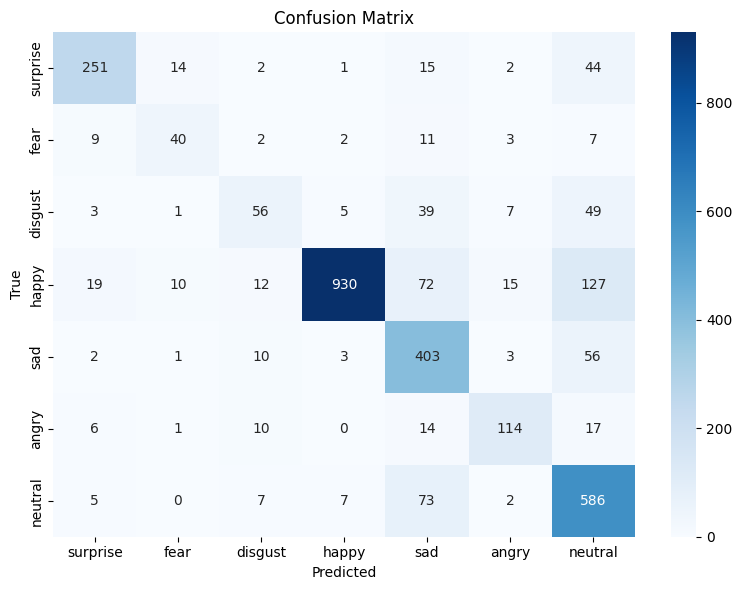

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd

# Put model in evaluation mode
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate classification report
emotion_names = ["surprise", "fear", "disgust", "happy", "sad", "angry", "neutral"]
report = classification_report(all_labels, all_preds, target_names=emotion_names)
print("Classification Report:\n")
print(report)

# Optional: plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
df_cm = pd.DataFrame(cm, index=emotion_names, columns=emotion_names)

plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()